In [1]:
from scipy.io import loadmat # load matlab file
import matplotlib.pyplot as plt # plot
import pickle # save python data
import cv2 # perspective transformation
import numpy as np 
import time

behav_mat = loadmat('behav_new.mat'); # read data

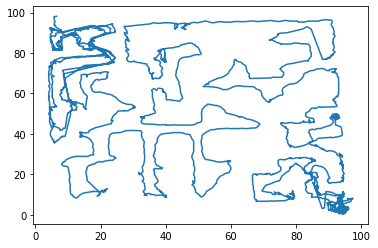

In [14]:
# position number 13
behav_positions = behav_mat['behav']["position_original"][0][0]
behav_time = behav_mat['behav']['time'][0][0]
# delete first 50 frames (~1.7s), when the mouse is not in the maze
delete_start = 50
behav_positions = np.delete(behav_positions, range(0,delete_start),0)
behav_time = np.delete(behav_time, range(0,delete_start))

# delete NAN values
nan_mask = np.isnan(behav_positions).any(axis=1)
behav_time_original = behav_time
behav_positions = behav_positions[~nan_mask, ]
behav_time = behav_time[~nan_mask]
plt.plot(behav_positions[:,0], behav_positions[:,1])

behav_roi = behav_mat['behav']['ROI'][0][0][0]
roi = np.int32([behav_roi[0], behav_roi[0]+behav_roi[2], behav_roi[1], behav_roi[1]+behav_roi[3]] )


In [15]:
# data cleaning, delete wrong data point by speed
behav_len = behav_positions.shape[0]
nan_seq_len = 0
delta = 0
max_speed = 60 # 100 cm/s

behav_positions_tmp = behav_positions
behav_time_tmp = behav_time
good_ind_diff = 1
for i in range(1,behav_len):
    delta = np.sqrt(np.sum(np.square(behav_positions[i,] - behav_positions[i-good_ind_diff,])))
    time_diff = behav_time[i] - behav_time[i-good_ind_diff]
    speed_tmp = delta/time_diff*1000
    if speed_tmp > max_speed:
        print(i, behav_positions[i,],behav_positions[i-1,], speed_tmp, time_diff, delta)
        behav_positions_tmp[i,] = np.nan
        good_ind_diff += 1
    else:
        good_ind_diff = 1


nan_mask2 = np.isnan(behav_positions_tmp).any(axis=1)
behav_positions = behav_positions_tmp[~nan_mask2, ]
behav_time = behav_time_tmp[~nan_mask2]


351 [ 4.92500697 92.16798766] [ 4.643578   91.88655869] 398.0006661530094 1 0.3980006661530094
352 [ 4.69048283 92.21489249] [nan nan] 165.8336108970932 2 0.3316672217941864
471 [23.60485485 78.76493297] [22.93646105 79.6443985 ] 1104.6311136055895 1 1.1046311136055895
472 [23.97774824 78.46239682] [nan nan] 71.60219198961519 22 1.5752482237715342
550 [10.06108568 56.28579399] [10.13144292 56.28579399] 70.35724248838982 1 0.07035724248838982
681 [ 5.20643594 45.73220762] [ 5.34715043 45.66185037] 157.32357691347767 1 0.15732357691347768
859 [19.46550376 81.56749646] [20.40360032 80.77011438] 1231.1959031992376 1 1.2311959031992377
860 [19.27788444 81.89583026] [nan nan] 61.230871715848366 26 1.5920026646120575
974 [ 4.643578   87.24298069] [ 4.643578   86.82083723] 422.14345493033534 1 0.42214345493033534
975 [ 4.643578   87.66512414] [nan nan] 281.4289699535569 3 0.8442869098606707
1050 [23.18974712 80.43239961] [21.71693551 81.56749646] 1859.4673660675526 1 1.8594673660675525
1051 [2

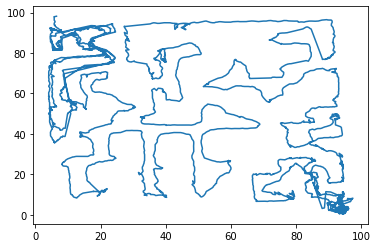

In [16]:
# get start, end time
start_time = behav_time[0]
end_time = behav_time[-1]
total_time = end_time- start_time
stay_time = np.append(np.ediff1d(behav_time),33)
# get end index
end_index = np.where(behav_time_original == end_time)[0][0]
behav_time_original = behav_time_original[0:(end_index+1)]
# define behavior x, y, roi
behav_x = behav_positions[:,0]
behav_y = behav_positions[:,1]
behav_roi = behav_mat['behav'][0][0][12][0]
track_length = behav_mat['behav'][0][0][-1][0]

# plt.plot(behav_positions[:,0], behav_positions[:,1])
plt.plot(behav_positions[:,0], behav_positions[:,1])

In [17]:
# Read the video
video_name = "behavCam1.avi"


In [18]:
# calculate mean frame
def get_meanframe(video_name):
    cap = cv2.VideoCapture(video_name)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(length):    # Capture frame-by-frame
        ret, frame = cap.read()  # ret = 1 if the video is captured; frame is the image
        if i == 0: # initialize mean frame
            mean_frame = np.zeros_like(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        # Our operations on the frame come here    
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/length
        # img = frame/length
        mean_frame = mean_frame + img
    
    return mean_frame
    # img = cv2.flip(frame,1)   # flip left-right  
    # img = cv2.flip(img,0)     # flip up-down
    # print(i)
    # Display the resulting image
    # cv2.imshow('Video Capture',img)
# When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()
mean_frame = get_meanframe(video_name)

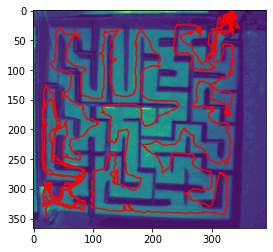

In [19]:
# plot trace on mean_frame
import matplotlib.pyplot as plt
ori_positions = behav_positions * behav_roi[2]/track_length

plt.plot(ori_positions[:,0],ori_positions[:,1], color = "red")
plt.imshow(mean_frame.astype(int))


In [20]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect


In [21]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	# maxWidth = max(int(widthA), int(widthB))
	maxWidth = 360
    # compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	# maxHeight = max(int(heightA), int(heightB))
	maxHeight = 360
    # now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped_image = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# warped_positions = cv2.perspectiveTransform(np.array([ori_positions]) , M)
	# return the warped image
	return warped_image, M


In [22]:
import numpy as np
import cv2
import pdb
# ============================================================================
roi = np.int32([behav_roi[0], behav_roi[0]+behav_roi[2], behav_roi[1], behav_roi[1]+behav_roi[3]] )
equ_meanframe = cv2.equalizeHist(np.uint8(mean_frame[roi[2]:roi[3], roi[0]:roi[1]]))
ori_positions = behav_positions * behav_roi[2]/track_length
FINAL_LINE_COLOR = (255, 100, 0)
WORKING_LINE_COLOR = (127, 127, 127)

# ============================================================================

class PolygonDrawer(object):
    def __init__(self, window_name):
        self.window_name = window_name # Name for our window

        self.done = False # Flag signalling we're done
        self.current = (0, 0) # Current position, so we can draw the line-in-progress
        self.points = [] # List of points defining our polygon


    def on_mouse(self, event, x, y, buttons, user_param):
        # Mouse callback that gets called for every smouse event (i.e. moving, clicking, etc.)

        if self.done: # Nothing more to do
            return

        if event == cv2.EVENT_MOUSEMOVE:
            # We want to be able to draw the line-in-progress, so update current mouse position
            self.current = (x, y)
        elif event == cv2.EVENT_LBUTTONDOWN:
            # Left click means adding a point at current position to the list of points
            print("Adding point #%d with position(%d,%d)" % (len(self.points), x, y))
            self.points.append((x, y))
        elif event == cv2.EVENT_RBUTTONDOWN:
            # Right click means we're done
            print("Completing polygon with %d points." % len(self.points))
            self.done = True


    def run(self):
        # Let's create our working window and set a mouse callback to handle events
        cv2.namedWindow(self.window_name, flags=cv2.WINDOW_AUTOSIZE)
        cv2.imshow(self.window_name, equ_meanframe)
        cv2.waitKey(1)
        cv2.setMouseCallback(self.window_name, self.on_mouse)

        while(not self.done):
            # This is our drawing loop, we just continuously draw new images
            # and show them in the named window
            canvas = equ_meanframe
            # canvas = np.zeros(CANVAS_SIZE, np.uint8)
            cv2.polylines(canvas,  np.int32([ori_positions]), False, FINAL_LINE_COLOR, 1)

            if (len(self.points) > 0):
                # Draw all the current polygon segments
                cv2.polylines(canvas, np.array([self.points]), False, FINAL_LINE_COLOR, 3)
                # And  also show what the current segment would look like
                # cv2.line(canvas, self.points[-1], self.current, WORKING_LINE_COLOR)
            # Update the window
            cv2.imshow(self.window_name, canvas)
            # And wait 50ms before next iteration (this will pump window messages meanwhile)
            if cv2.waitKey(50) == 27: # ESC hit
                self.done = True

        # User finised entering the polygon points, so let's make the final drawing
        canvas = equ_meanframe

        # of a filled polygon
        if (len(self.points) > 0):
            cv2.polylines(canvas, np.array([self.points]),True, FINAL_LINE_COLOR, thickness = 5)
        # And show it
        cv2.imshow(self.window_name, canvas)
        # Waiting for the user to press any key
        cv2.waitKey()
        
        # Four points transform
        warped_image, M = four_point_transform(equ_meanframe, np.asarray(self.points))
        cv2.imshow("Processed Maze", warped_image)
        warped_positions = cv2.perspectiveTransform(np.array([ori_positions]) , M)[0]
        # Waiting for the user to press any key
        cv2.waitKey()

        cv2.destroyWindow(self.window_name)
        cv2.destroyWindow("Processed Maze")
       
        return warped_image, warped_positions, M

# ============================================================================

if __name__ == "__main__":
    pd = PolygonDrawer("Original: select 4 maze corners")
    warped_image,warped_positions, M  = pd.run()
    cv2.imwrite("polygon.png", warped_image)
    print("Polygon = %s" % pd.points)
    
    with open('PerspTrans.pkl', 'wb') as f:
        pickle.dump(M, f)

Adding point #0 with position(14,17)
Adding point #1 with position(9,338)
Adding point #2 with position(329,344)
Adding point #3 with position(340,7)
Polygon = [(14, 17), (9, 338), (329, 344), (340, 7)]


In [23]:
cv2.destroyWindow("Original: select 4 maze corners")
cv2.destroyWindow("Processed Maze")


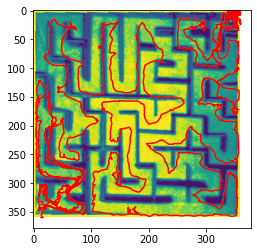

In [24]:
maxWidth = 360
maxHeight = 360
neg_mask = (warped_positions<0).any(axis =1)
processed_pos = warped_positions
processed_pos[warped_positions <0] = 0
processed_pos[warped_positions[:,0] >maxWidth, 0] = maxWidth
processed_pos[warped_positions[:,1] >maxHeight, 1] = maxHeight

plt.imshow(warped_image)
plt.plot(processed_pos[:,0], processed_pos[:,1], color = "red")


In [25]:
_nbins = 12
_coords_range = [[0,maxWidth +0.01],[0, maxHeight+0.01]]
activation = stay_time
import scipy.stats
def calculate_ratemap(agent_poss, activation, statistic='mean'):
    xs = agent_poss[:,0]
    ys = agent_poss[:,1]

    return scipy.stats.binned_statistic_2d(
        xs,
        ys,
        activation,
        bins=_nbins,
        statistic=statistic,
        range=_coords_range,
        expand_binnumbers = True)

occu_time, xbin_edges, ybin_edges, bin_numbers = calculate_ratemap(processed_pos, activation, statistic = "sum")

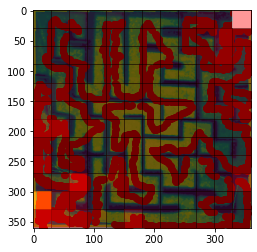

In [26]:
def plot_ratemap(ratemap, ax=None, title=None, *args, **kwargs):  # pylint: disable=keyword-arg-before-vararg
    """Plot ratemaps."""
    if ax is None:
        ax = plt.gca()
    # Plot the ratemap
    ax.imshow(ratemap, interpolation='none', *args, **kwargs)
    # ax.pcolormesh(ratemap, *args, **kwargs)
    ax.axis('off')
    if title is not None:
        ax.set_title(title)

# Plot the activation maps
#plot_ratemap(np.transpose(occu_time), cmap=cm, alpha = 0.8)
plt.imshow(warped_image)
plt.scatter(processed_pos[:,0], processed_pos[:,1], color = "red")

ax = plt.gca()
ticks = np.linspace(0, 360, _nbins+1)
ax.pcolor(ticks, ticks, np.transpose(occu_time), cmap='hot', alpha = 0.6)

# plt.scatter([0,1, 2, 3], [0,1, 2, 3])


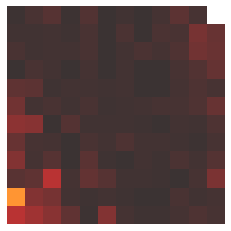

In [27]:
cm="hot"
plot_ratemap(np.transpose(occu_time), cmap=cm, alpha = 0.8)


In [28]:
def transform_bin(bin_numbers):
    # rotate bin by 90 degree
    y = 13 - bin_numbers[1,:]
    x = bin_numbers[0,:]
    return np.array([x,y])

In [29]:
transformed_bin_number = transform_bin(bin_numbers)


In [30]:
transformed_bin_number[:, 1:100]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], dtype=int64)

In [31]:
class Cell:
    """A cell in the maze.

    A maze "Cell" is a point in the grid which may be surrounded by walls to
    the north, east, south or west.

    """

    # A wall separates a pair of cells in the N-S or W-E directions.
    wall_pairs = {'N': 'S', 'S': 'N', 'E': 'W', 'W': 'E'}

    def __init__(self, x, y):
        """Initialize the cell at (x,y). At first it is surrounded by walls."""

        self.x, self.y = x, y
        self.walls = {'N': True, 'S': True, 'E': True, 'W': True}

    def has_all_walls(self):
        """Does this cell still have all its walls?"""

        return all(self.walls.values())

    def knock_down_wall(self, other, wall):
        """Knock down the wall between cells self and other."""

        self.walls[wall] = False
        other.walls[Cell.wall_pairs[wall]] = False


In [32]:
class Maze:
    """    
    This constructs a maze with a given graph, represented as a grid of cells.
    The maze consists of square cells the width of a corridor.
    Each cell in the maze has an (x,y) location, with x,y = 0,...,n
    y runs top to bottom.
    Each cell is also given a unique integer cell number.
    The present maze consists of straight runs, each run terminates in a branch point or 
    an end point. 
    
    graph: dict, keys-nodes: values-their neighbors
    maze_map: list of Cells
    decision_node: nodes with decision point
    runs: list of list of nodes
    """

    def __init__(self, nx, ny, graph, ix=0, iy=0, start_node = 1, end_node = 144):
        """Initialize the maze grid.
        The maze consists of nx x ny cells and will be constructed starting
        at the cell indexed at (ix, iy).

        """
        self.nx, self.ny = nx, ny
        self.ix, self.iy = ix, iy
        self.cell_num = nx * ny
        self.graph = graph
        self.maze_map = [[Cell(x, y) for y in range(ny)] for x in range(nx)]
        # Direction: neightbor - current
        self.to_direction = {(-1, 0): 'W',
                 (1, 0): 'E',
                 (0, 1):'S',
                 (0, -1): 'N'}
        self.is_bidirectional = self.check_bidirectional(graph) # check if the graph is bidirectional
        if self.is_bidirectional:
            self.make_maze() # knock down walls according to graph
            self.repeated_parents = set()
            self.decision_nodes = []
            self.runs = self.get_run_from_current(start_node, graph)
            self.shortest_path = self.BFS_SP(graph, start_node, end_node)
            self.run_levels, self.cell_levels = self.get_levels_for_runs()
            self.cell_dists = self.get_distance_to_goal(end_node = 144)
            # self.cell_levels = self.get_levels_for_cells()
            
    def cell_at(self, x, y):
        """Return the Cell object at (x,y)."""
        return self.maze_map[x][y]
    
    def idx_to_loc(self, idx):
        # convert index to location (x,y), note: location start from 0
        cell_w = idx % self.nx
        cell_h = idx // self.ny
        return cell_w, cell_h
    
    def loc_to_idx(self, cell_w, cell_h):
        # convert location (x,y) to index
        idx = cell_w * self.nx + cell_h +1
        return idx
    
    def check_bidirectional(self, graph):
        # check if the maze is bidirectional
        is_bidirectional = True
        for node in graph.keys():
            child_nodes = graph[node]
            for child in child_nodes:
                if not node in graph[child]:
                    print("Warning: node " + str(node) + " not in node " + str(child))
                    is_bidirectional = False
        if is_bidirectional:
            print("The maze is bidirectional, Ye!")
        else:
            print("Something is wrong, check log")
        return is_bidirectional

    def get_run_from_current(self, current_node, graph, runs = []):
        # get all runs from current node. Runs are defined as independent decision unit consisting a group of nodes
        # return runs
        done = False
        run = [current_node] # put current node in run
        self.repeated_parents.add(current_node) # add current node to repeated node (each node only belongs to one run)
        children_node = [value for value in graph[current_node] if not value in self.repeated_parents] # delete repeated children

        while not done:
            if len(children_node) >= 2: # child nodes >=2, decision point
                print("Node " + str(current_node) + " is Decision point")
                self.decision_nodes.append(current_node)
                runs.append(run) # 
                # b.set_trace()
                for child in children_node:
                    runs = self.get_run_from_current(child, graph, runs = runs)
                done = True
            elif len(children_node) == 0: # leaf node
                print("Node " + str(current_node) + " is Leaf node")
                runs.append(run)
                done = True
            else:
                current_node = children_node[0]
                # print(current_node)
                self.repeated_parents.add(current_node)
                run.append(current_node)
                # pdb.set_trace()
                children_node = [value for value in graph[current_node] if not value in self.repeated_parents] # parent will not be children's children
        return runs
    
    def get_distance_to_goal(self, end_node = 144):
        # calculate distance from any nodes to goal (default to 144)
        labeled_cells = [144]
        next_cells =[]
        current_dist = 0
        cell_dists = [0]*self.cell_num
        cell_dists[end_node - 1] = 0
        next_cells = self.graph[end_node]
        while(len(labeled_cells) < self.cell_num):
            current_dist += 1
            next_cells_tmp = []
            for i_cell in next_cells:
                if i_cell not in labeled_cells:
                    cell_dists[i_cell-1] = current_dist
                    next_cells_tmp = next_cells_tmp + self.graph[i_cell]
                    labeled_cells.append(i_cell)
            next_cells = next_cells_tmp
        return cell_dists
    
    def get_levels_for_runs(self):
        # calculate levels for all runs (and cells)
        # a level consists a group of cells separated by decision points
        decision_nodes_on_shortest = [x for x in self.decision_nodes if x in  self.shortest_path]
        level_seq = list(range(len(decision_nodes_on_shortest)))
        run_levels = [0]*len(self.runs)
        cell_levels = [0]*self.cell_num
        labeled_cells = []
        for i in range(len(self.runs)):
            # if runs are on shortest path, the last node should be decision nodes and determine its level
            if self.runs[i][-1] in decision_nodes_on_shortest:
                run_levels[i] = level_seq[decision_nodes_on_shortest.index(self.runs[i][-1])]
            # if runs are not on shortest path, the neighbor of the first node should be decision nodes and determine its level
            else:
                first_neighbors = self.graph[self.runs[i][0]]
                decision_node_last = [val for val in first_neighbors if val in labeled_cells][0]
                run_levels[i] = cell_levels[decision_node_last-1]
                
            for i_cell in self.runs[i]:
                cell_levels[i_cell-1] = run_levels[i]
                labeled_cells.append(i_cell)
        return run_levels, cell_levels
        
    # Function to find the shortest
    # path between two nodes of a graph
    def BFS_SP(self,graph, start, goal):
        explored = []

        # Queue for traversing the
        # graph in the BFS
        queue = [[start]]

        # If the desired node is
        # reached
        if start == goal:
            print("Same Node")
            return(None)

        # Loop to traverse the graph
        # with the help of the queue
        while queue:
            path = queue.pop(0)
            node = path[-1]

            # Condition to check if the
            # current node is not visited
            if node not in explored:
                neighbours = graph[node]

                # Loop to iterate over the
                # neighbours of the node
                for neighbour in neighbours:
                    new_path = list(path)
                    new_path.append(neighbour)
                    queue.append(new_path)

                    # Condition to check if the
                    # neighbour node is the goal
                    if neighbour == goal:
                        print("Shortest path = ", *new_path)
                        return(new_path)
                explored.append(node)

        # Condition when the nodes
        # are not connected
        print("So sorry, but a connecting"\
                    "path doesn't exist :(")
        return(None)
    
    def __str__(self):
        """Return a (crude) string representation of the maze."""

        maze_rows = ['-' * self.nx * 2]
        for y in range(self.ny):
            maze_row = ['|']
            for x in range(self.nx):
                if self.maze_map[x][y].walls['E']:
                    maze_row.append(' |')
                else:
                    maze_row.append('  ')
            maze_rows.append(''.join(maze_row))
            maze_row = ['|']
            for x in range(self.nx):
                if self.maze_map[x][y].walls['S']:
                    maze_row.append('-+')
                else:
                    maze_row.append(' +')
            maze_rows.append(''.join(maze_row))
        return '\n'.join(maze_rows)
    
    def maze_plot(self, axes = None):
        # plot maze with matplotlib.plot
        aspect_ratio = self.nx / self.ny
        # Pad the maze all around by this amount.
        padding = 0.05
        # Height and width of the maze image (excluding padding), in pixels
        height = 6
        width = int(height * aspect_ratio)
        # Scaling factors mapping maze coordinates to image coordinates
        scy, scx = height / self.ny, width / self.nx
        # Write the SVG image file for maze
        # SVG preamble and styles.
        if axes == None:
            fig = plt.figure(figsize=[(height + 2 * padding), (width + 2 * padding)])
            axes = plt.gca()
            axes.invert_yaxis()
        
        # Draw the "South" and "East" walls of each cell, if present (these
        # are the "North" and "West" walls of a neighbouring cell in
        # general, of course).
        for x in range(self.nx):
            for y in range(self.ny):
                if self.cell_at(x, y).walls['S']:
                    x1, y1, x2, y2 = x * scx, (y + 1) * scy, (x + 1) * scx, (y + 1) * scy
                    axes.plot([x1, x2], [y1, y2], color = "black")
                if self.cell_at(x, y).walls['E']:
                    x1, y1, x2, y2 = (x + 1) * scx, y * scy, (x + 1) * scx, (y + 1) * scy
                    axes.plot([x1, x2], [y1, y2], color = "black")
        # Draw the North and West maze border, which won't have been drawn
        # by the procedure above.
        axes.plot([0, 0], [0, height], color = "black")
        axes.plot([0, width], [0, 0], color = "black")
        return axes
    
    def maze_plot_num(self, axes = None, mode='cells',numcol='blue'):
        '''
        adds numbering to an existing maze plot given by axes
        m: maze
        mode: 'cells','runs','nodes': depending on what gets numbered
        numcol: color of the numbers
        '''
        axes = self.maze_plot(axes)
        # plot maze with matplotlib.plot
        aspect_ratio = self.nx / self.ny
        # Pad the maze all around by this amount.
        padding = 0.05
        # Height and width of the maze image (excluding padding), in pixels
        height = 6
        width = int(height * aspect_ratio)
        # Scaling factors mapping maze coordinates to image coordinates
        scy, scx = height / self.ny, width / self.nx

        if mode=='nodes':
            for j,r in enumerate(self.runs):
                x, y = self.idx_to_loc(r[-1]-1)
                plt.text((x+0.25)*scx, (y+0.65)*scy, '{:d}'.format(j+1),color=numcol) # number the ends of a run    
        
        if mode=='cells':
            for j in range(self.nx * self.ny):
                x, y = self.idx_to_loc(j)
                plt.text((x+0.25)*scx, (y+0.65)*scy, '{:d}'.format(j+1),color=numcol) # number the cells    
        
        if mode=='dists':
            for j in range(self.nx * self.ny):
                x, y = self.idx_to_loc(j)
                plt.text((x+0.25)*scx, (y+0.65)*scy, '{:d}'.format(self.cell_dists[j]),color=numcol) # number the cells    

        if mode=='decisions':
            for j,d in enumerate(self.decision_nodes):
                x, y = self.idx_to_loc(d-1)
                plt.text((x+0.25)*scx, (y+0.65)*scy, '{:d}'.format(j+1),color=numcol) # number the cells    

    
    def write_svg(self, filename):
        """Write an SVG image of the maze to filename."""

        aspect_ratio = self.nx / self.ny
        # Pad the maze all around by this amount.
        padding = 10
        # Height and width of the maze image (excluding padding), in pixels
        height = 500
        width = int(height * aspect_ratio)
        # Scaling factors mapping maze coordinates to image coordinates
        scy, scx = height / self.ny, width / self.nx

        def write_wall(ww_f, ww_x1, ww_y1, ww_x2, ww_y2):
            """Write a single wall to the SVG image file handle f."""

            print('<line x1="{}" y1="{}" x2="{}" y2="{}"/>'
                  .format(ww_x1, ww_y1, ww_x2, ww_y2), file=ww_f)

        # Write the SVG image file for maze
        with open(filename, 'w') as f:
            # SVG preamble and styles.
            print('<?xml version="1.0" encoding="utf-8"?>', file=f)
            print('<svg xmlns="http://www.w3.org/2000/svg"', file=f)
            print('    xmlns:xlink="http://www.w3.org/1999/xlink"', file=f)
            print('    width="{:d}" height="{:d}" viewBox="{} {} {} {}">'
                  .format(width + 2 * padding, height + 2 * padding,
                          -padding, -padding, width + 2 * padding, height + 2 * padding),
                  file=f)
            print('<defs>\n<style type="text/css"><![CDATA[', file=f)
            print('line {', file=f)
            print('    stroke: #000000;\n    stroke-linecap: square;', file=f)
            print('    stroke-width: 5;\n}', file=f)
            print(']]></style>\n</defs>', file=f)
            # Draw the "South" and "East" walls of each cell, if present (these
            # are the "North" and "West" walls of a neighbouring cell in
            # general, of course).
            for x in range(self.nx):
                for y in range(self.ny):
                    if self.cell_at(x, y).walls['S']:
                        x1, y1, x2, y2 = x * scx, (y + 1) * scy, (x + 1) * scx, (y + 1) * scy
                        write_wall(f, x1, y1, x2, y2)
                    if self.cell_at(x, y).walls['E']:
                        x1, y1, x2, y2 = (x + 1) * scx, y * scy, (x + 1) * scx, (y + 1) * scy
                        write_wall(f, x1, y1, x2, y2)
            # Draw the North and West maze border, which won't have been drawn
            # by the procedure above.
            print('<line x1="0" y1="0" x2="{}" y2="0"/>'.format(width), file=f)
            print('<line x1="0" y1="0" x2="0" y2="{}"/>'.format(height), file=f)
            print('</svg>', file=f)

    def make_maze(self):
        ##  Knock down walls according to graph
        ## Note: location (x, y) start from 0, while index (idx) start from 1, BE CAREFUL!
        # Total number of cells.
        n_total = self.nx * self.ny
        for i in range(n_total):
            current_idx = i+1
            current_x, current_y = self.idx_to_loc(current_idx-1)
            current_cell = self.cell_at(current_x, current_y)
            neighbor_idxs = self.graph[current_idx]
            for neighbor_idx in neighbor_idxs:
                #pdb.set_trace()
                neighbor_x, neighbor_y = self.idx_to_loc(neighbor_idx-1)
                next_cell = self.cell_at(neighbor_x, neighbor_y)
                # print((current_idx, neighbor_idx) )

                # pdb.set_trace()
                diff_loc = (neighbor_x-current_x, neighbor_y-current_y)
                neighbor_dir = self.to_direction[diff_loc]
                current_cell.knock_down_wall(next_cell, neighbor_dir)
               
            

In [34]:
# Maze to graph (stored in list!)
# 12 x 12 maze, 144 cells
# Cell order: left -> right, up -> down 
import pdb
import networkx as nx
nx = 12
ny = 12
total_bin = nx*ny
graph = {1: [2, 13],
         2: [1],
         3: [4, 15],
         4: [3, 5],
         5: [4, 6],
         6: [5, 7, 18],
         7: [6, 8],
         8: [7],
         9: [10, 21],
         10: [9, 11],
         11: [10, 12],
         12: [11, 24],
         13: [1, 14, 25],
         14: [13, 26],
         15: [3, 27],
         16: [17, 28],
         17: [16, 18, 29],
         18: [6, 17],
         19: [20, 31],
         20: [19, 21],
         21: [9, 20],
         22: [23, 34],
         23: [22, 24],
         24: [12, 23,36],
         25: [13],
         26: [14,27],
         27: [26, 15],
         28: [16],
         29: [17, 30],
         30: [29, 31, 42],
         31: [30, 19],
         32: [33, 44],
         33: [32, 34],
         34: [22, 33],
         35: [36],
         36: [35, 24],
         37: [38, 49],
         38: [37, 39],
         39: [40, 38, 51],
         40: [39],
         41: [42],
         42: [41, 30],
         43: [55],
         44: [32, 45],
         45: [44, 46],
         46: [45, 47],
         47: [46, 48],
         48: [47, 60],
         49: [37, 61],
         50: [51, 62],
         51: [39, 50,52],
         52: [51],
         53: [54],
         54: [53, 55,66],
         55: [43, 54,67],
         56: [57, 68],
         57: [56, 58],
         58: [57, 59],
         59: [58, 60],
         60: [48, 59],
         61: [49, 73],
         62: [50, 74],
         63: [64, 75],
         64: [63, 65],
         65: [64, 66],
         66: [54, 65],
         67: [55, 79],
         68: [56, 69],
         69: [68, 70],
         70: [69, 71],
         71: [70, 72],
         72: [71, 84],
         73: [61, 85],
         74: [62, 75],
         75: [74, 63],
         76: [77, 88],
         77: [76, 89],
         78: [79, 90],
         79: [78, 67],
         80: [81, 92],
         81: [80, 82],
         82: [81, 94],
         83: [95, 84],
         84: [72, 83, 96],
         85: [73, 97],
         86: [98],
         87: [88, 99],
         88: [87, 76],
         89: [77, 101],
         90: [78, 91],
         91: [90, 103],
         92: [80, 104],
         93: [105],
         94: [82, 95,106],
         95: [83, 94],
         96: [84],
         97: [85, 98, 109],
         98: [97, 86],
         99: [87, 100],
         100: [99, 112],
         101: [89, 102],
         102: [101, 114],
         103: [91, 104],
         104: [103, 92],
         105: [93, 106],
         106: [105, 94],
         107: [108, 119],
         108: [107, 120],
         109: [97, 110,121],
         110: [109, 122],
         111: [112, 123],
         112: [100, 111],
         113: [114, 125],
         114: [113, 102],
         115: [116, 127],
         116: [115, 117],
         117: [116, 129],
         118: [119, 130],
         119: [118, 107],
         120: [108],
         121: [109, 133],
         122: [110, 123],
         123: [111, 122],
         124: [125, 136],
         125: [124, 113],
         126: [127, 138],
         127: [115, 126],
         128: [129, 140],
         129: [128, 117,141],
         130: [118, 131,142],
         131: [130, 132],
         132: [131, 144],
         133: [121, 134],
         134: [133, 135],
         135: [134],
         136: [124, 137],
         137: [136, 138],
         138: [137, 126],
         139: [140],
         140: [139, 128],
         141: [129, 142],
         142: [130, 141,143],
         143: [142],
         144: [132],
        }


In [35]:
# Function to find the shortest
# path between two nodes of a graph
def BFS_SP(graph, start, goal):
    explored = []
     
    # Queue for traversing the
    # graph in the BFS
    queue = [[start]]
     
    # If the desired node is
    # reached
    if start == goal:
        print("Same Node")
        return(None)
     
    # Loop to traverse the graph
    # with the help of the queue
    while queue:
        path = queue.pop(0)
        node = path[-1]
         
        # Condition to check if the
        # current node is not visited
        if node not in explored:
            neighbours = graph[node]
             
            # Loop to iterate over the
            # neighbours of the node
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                 
                # Condition to check if the
                # neighbour node is the goal
                if neighbour == goal:
                    print("Shortest path = ", *new_path)
                    return(new_path)
            explored.append(node)
 
    # Condition when the nodes
    # are not connected
    print("So sorry, but a connecting"\
                "path doesn't exist :(")
    return(None)


In [37]:
start_node = 1
end_node = 144
test_maze = Maze(nx, ny, graph)
test_maze.make_maze()
shortest_path = BFS_SP(graph, start_node, end_node)
cell_dists = test_maze.cell_dists
behav_nodes = test_maze.loc_to_idx(transformed_bin_number[0,:]-1, transformed_bin_number[1,:]-1)

The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Leaf node
Node 25 is Leaf node
Shortest path =  1 13 14 26 27 15 3 4 5 6 18 17 29 30 31 19 20 21 9 10 11 12 24 23 22 34 33 32 44 45 46 47 48 60 59 58 57 56 68 69 70 71 72 84 8

In [27]:
# function to interpolate nodes in the maze
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def interpolate_pos_maze(behav_time, behav_nodes, behav_time_original, graph, test_maze):
    
    # interpolate behavior position on graph
    behav_nodes_interpolated = np.zeros_like(behav_time_original)
    # initialize first node to 1
    behav_nodes_interpolated[0] = 1
    before_node = 1
    after_node = 1

    # missing data from start
    if behav_time_original[0] < behav_time[0]:
        behav_nodes_interpolated[0:np.where(behav_time_original == behav_time[0])[0][0]] = before_node

    for i in range(len(behav_time)-1):
        before_time = behav_time[i]
        after_time = behav_time[i+1]
        before_node = behav_nodes[i]
        after_node = behav_nodes[i+1]
        before_index = np.where(behav_time_original == before_time)[0][0]
        after_index = np.where(behav_time_original == after_time)[0][0]
        behav_nodes_interpolated[before_index] = before_node
        behav_nodes_interpolated[after_index] = after_node
        # if there is missing value in between
        if after_index != before_index+1:
            # if nodes before and after missing frames are equal, assign to frames
            if before_node == after_node:
                behav_nodes_interpolated[(before_index+1):after_index] = before_node
            # when nodes are different, check if previous node is in the neighbor of after node
            elif before_node in graph[after_node]:
                # assign first half to previous node and latter half to after node
                half_index = before_index + (after_index-before_index)//2 +1
                behav_nodes_interpolated[(before_index+1):half_index] = before_node
                behav_nodes_interpolated[half_index:after_index] = after_node
            else:
                # the nodes are different and are not neighbor to each other, we need to find shortest path and interpolate
                path_nodes = test_maze.BFS_SP(graph = graph, start = before_node, goal = after_node)[1:-1]
                if len(path_nodes) == 1:
                    behav_nodes_interpolated[(before_index+1):after_index] = path_nodes[0]
                else:
                    # print([before_index, after_index])
                    tmp_list = behav_nodes_interpolated[(before_index+1):after_index]
                    k, m = divmod(len(tmp_list), len(path_nodes))
                    for i in range(len(path_nodes)):
                        tmp_list[i*k+min(i, m):(i+1)*k+min(i+1, m)] = path_nodes[i]
    # all frame should be interpolated
    #pdb.set_trace()
    assert(len(np.where(behav_nodes_interpolated == 0)[0]) == 0)
    return(behav_nodes_interpolated)

behav_nodes_interpolated = interpolate_pos_maze(behav_time, behav_nodes, behav_time_original, graph, test_maze)
# output: behav_nodes_interpolated

Shortest path =  37 38 39 51 50 62 74 75 63 64 65 66 54 55 67 79 78 90 91 103 104 92 80 81 82 94 95 83 84 72 71 70 69 68 56 57 58 59 60 48 47 46 45 44 32 33 34 22 23 24 12 11 10 9 21 20 19 31 30 29 17 18 6 5 4 3 15 27 26
Shortest path =  39 51 50 62 74 75 63 64 65 66 54 55 67 79 78 90 91 103 104 92 80 81 82 94 95 83 84 72 71 70 69 68 56 57 58 59 60 48 47 46 45 44 32 33 34 22 23 24 12 11 10 9 21 20 19 31 30 29 17 16
Shortest path =  37 38 39 51 50 62 74 75 63 64 65 66 54 55 67 79 78 90 91 103 104 92 80 81 82 94 95 83 84 72 71 70 69 68 56 57 58 59 60 48 47 46 45 44 32 33 34 22 23 24 12 11 10 9 21 20 19 31 30 29 17 18 6 5 4 3 15 27 26
Shortest path =  26 27 15 3 4 5 6 18 17 29 30 31 19 20 21 9 10 11 12 24 23 22 34 33 32 44 45 46 47 48 60 59 58 57 56 68 69 70 71 72 84 83 95 94 82 81 80 92 104 103 91 90 78 79 67 55 54 66 65 64 63 75 74 62 50 51 39 38
Shortest path =  39 51 50 62 74 75 63 64 65 66 54 55 67 79 78 90 91 103 104 92 80 81 82 94 95 83 84 72 71 70 69 68 56 57 58 59 60 48 47 46 45 

In [29]:
def get_direction(behav_nodes_interpolated, test_maze, shortest_path):
    # Function to get direction (right or wrong)
    # 1 is correct direction (to goal on correct path, or to correct path on incorrect path)
    # 0 is incorrect direction (to start on correct path, or to leaf on incorrect path)
    behav_dir = np.zeros_like(behav_nodes_interpolated)
    behav_dir[0] = 1
    behav_dir[-1] = 1
    for i in range(1, len(behav_dir)-1):
        # if current node equals next node, direction does not change
        if behav_nodes_interpolated[i] == behav_nodes_interpolated[i+1]:
            behav_dir[i] = behav_dir[i-1]
        else:
            if cell_dists[behav_nodes_interpolated[i]-1] > cell_dists[behav_nodes_interpolated[i+1]-1]:
                behav_dir[i] = 1
            else:
                behav_dir[i] = 0

    return(behav_dir)

behav_dir = get_direction(behav_nodes_interpolated, test_maze, shortest_path)

In [30]:
stay_time_original = np.append(np.ediff1d(behav_time_original),0)

# calculate time spent in each node
correct_time = 0
wrong_time = 0
for i in range(len(stay_time_original)):
    if (behav_nodes_interpolated[i] in shortest_path) & (behav_dir[i] == 1):
        correct_time += stay_time_original[i]
    else:
        wrong_time += stay_time_original[i]

    
print("Total time: " + str((correct_time+wrong_time)/1000) + " s, \n Time on correct path & direction: " + str(correct_time/1000) + " s (" + "{:.2f}".format(correct_time/total_time*100) + "%), \n Time on incorrect path or direction : "+ str(wrong_time/1000) + " s (" + "{:.2f}".format(wrong_time/total_time*100) + "%)")


Total time: 269.552 s, 
 Time on correct path & direction: 126.991 s (47.19%), 
 Time on incorrect path or direction : 142.561 s (52.98%)


In [31]:
# correct decision rate: current frame at decision point, next frame at next cell in among the shortest path
# total_decision = np.zeros(len(test_maze.decision_nodes))
correct_decision = np.zeros(len(test_maze.decision_nodes))
incorrect_decision = np.zeros(len(test_maze.decision_nodes))
for i in range(len(behav_nodes_interpolated)-1):
    # check current node is a decision node, and not the same as next node (decision is made)
    if (behav_nodes_interpolated[i] in test_maze.decision_nodes) & (behav_nodes_interpolated[i+1] in graph.get(behav_nodes_interpolated[i])):
        # decision node index
        current_decision_node = behav_nodes_interpolated[i]
        next_node = behav_nodes_interpolated[i+1]
        current_idx_decision = test_maze.decision_nodes.index(current_decision_node)
        if cell_dists[current_decision_node - 1] >  cell_dists[next_node]:
            correct_decision[current_idx_decision] += 1
        else:
            incorrect_decision[current_idx_decision] += 1
        
        
total_decision = correct_decision + incorrect_decision
# correct decision rate for each decision node
# correct_decision/(total_decision + 1e-12)

# overall correct rate
decision_rate = sum(correct_decision)/sum(total_decision)
print("Overall Correct Rate: " + "{:.2f}".format(decision_rate*100)+ "%")

Overall Correct Rate: 41.38%


In [32]:
# time spent in each level
total_levels = len(test_maze.decision_nodes)
time_levels = np.zeros(total_levels)
for i in range(len(stay_time_original)):
    level_ind = test_maze.cell_levels[behav_nodes_interpolated[i]-1]
    time_levels[level_ind] += stay_time_original[i]

first_half_time = np.sum(time_levels[:(len(time_levels)//2)])
total_time = np.sum(time_levels)
print("% Time spent in first 1/2 levels: " + "{:.2f}".format(first_half_time/total_time*100)+ "%")

% Time spent in first 1/2 levels: 38.75%


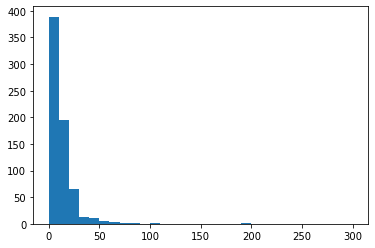

In [33]:
# Stop time at each bin
stop_time_tmp = 1
stop_time_record = []
for i in range(1,len(behav_nodes_interpolated)):
    if behav_nodes_interpolated[i] == behav_nodes_interpolated[i-1]:
        stop_time_tmp+=1
    else:
        stop_time_record.append(stop_time_tmp)
        stop_time_tmp = 1
# Delete first and last value: stop time at begining and end may have bias
stop_time_record.pop(0)
stop_time_record.pop(-1)

plt.hist(stop_time_record, range = [0,300], bins = 30)
stop_time_mean = np.mean(stop_time_record)
stop_time_median = np.median(stop_time_record)


In [34]:
 bin_travelled = 1
for i in range(2,len(behav_nodes_interpolated)):
    if behav_nodes_interpolated[i] != behav_nodes_interpolated[i-1]:
        bin_travelled+=1
speed_bin = bin_travelled / (total_time/1000)
print(speed_bin)
with open('speed_bin.pkl', 'wb') as f:
    pickle.dump([speed_bin], f)

# change to cm/s

2.5486733543064046


In [152]:
with open('behav_decision.pkl', 'wb') as f:
    pickle.dump([correct_time/1000, wrong_time/1000, correct_time/(correct_time+wrong_time), decision_rate, time_levels], f)

In [153]:
mylist = [behav_time_original, behav_nodes_interpolated, behav_dir]
with open('behav_processed.pkl', 'wb') as f:
    pickle.dump(mylist, f)

In [154]:
with open('maze1.pkl', 'wb') as f:
    pickle.dump(graph, f)

In [155]:
with open('stop_time.pkl', 'wb') as f:
    pickle.dump([stop_time_mean, stop_time_median], f)

In [40]:
stop_time_record.pop(-1)


21

In [56]:
len(time_levels)

17

In [27]:
test_maze.decision_nodes in test_maze.shortest_path

False

In [32]:
[x for x in test_maze.decision_nodes if x in  test_maze.shortest_path]

[1, 13, 6, 17, 30, 24, 84, 94, 55, 54, 51, 39, 97, 109, 129, 142, 130]

In [30]:
test_maze.shortest_path

[1,
 13,
 14,
 26,
 27,
 15,
 3,
 4,
 5,
 6,
 18,
 17,
 29,
 30,
 31,
 19,
 20,
 21,
 9,
 10,
 11,
 12,
 24,
 23,
 22,
 34,
 33,
 32,
 44,
 45,
 46,
 47,
 48,
 60,
 59,
 58,
 57,
 56,
 68,
 69,
 70,
 71,
 72,
 84,
 83,
 95,
 94,
 82,
 81,
 80,
 92,
 104,
 103,
 91,
 90,
 78,
 79,
 67,
 55,
 54,
 66,
 65,
 64,
 63,
 75,
 74,
 62,
 50,
 51,
 39,
 38,
 37,
 49,
 61,
 73,
 85,
 97,
 109,
 110,
 122,
 123,
 111,
 112,
 100,
 99,
 87,
 88,
 76,
 77,
 89,
 101,
 102,
 114,
 113,
 125,
 124,
 136,
 137,
 138,
 126,
 127,
 115,
 116,
 117,
 129,
 141,
 142,
 130,
 131,
 132,
 144]

In [36]:
stay_time_original

array([32, 32, 32, ..., 31, 32,  0])

In [51]:
len(behav_nodes)

3012

In [292]:
behav_nodes_interpolated[0] in shortest_path

True

In [158]:
# interpolate behavior position on graph
behav_nodes_original = np.ones_like(behav_time_original)
nan_mask_end = nan_mask[0:(end_index+1)]
# initialize first node to 1
behav_nodes_original[0] = 1
before_node = 1
after_node = 1

# missing data from start
if behav_nodes_original[0] < behav_time[0]
    behav_nodes_original[0:behav_nodes_original.index(behav_time[0])] = before_node

    
for i in range(len(behav_time))
    before_node = 1
    after_node = 1
    before_time = behav_time
    if behav_time_original[i] <= behav_time[0]: # before first good position
        behav_nodes_original[i] = 1
    elif behav_time_original[i] >= behav_time[-1]: # after last good position
        behav_nodes_original[i] = behav_nodes[-1]
    else: # between positions
        1
        
        

IndexError: index 3346 is out of bounds for axis 0 with size 3346

In [238]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

# interpolate behavior position on graph
behav_nodes_interpolated = np.zeros_like(behav_time_original)
nan_mask_end = nan_mask[0:(end_index+1)]
# initialize first node to 1
behav_nodes_interpolated[0] = 1
before_node = 1
after_node = 1

# missing data from start
if behav_time_original[0] < behav_time[0]:
    behav_nodes_interpolated[0:np.where(behav_time_original == behav_time[0])[0][0]] = before_node

for i in range(len(behav_time)-1):
    before_time = behav_time[i]
    after_time = behav_time[i+1]
    before_node = behav_nodes[i]
    after_node = behav_nodes[i+1]
    before_index = np.where(behav_time_original == before_time)[0][0]
    after_index = np.where(behav_time_original == after_time)[0][0]
    behav_nodes_interpolated[before_index] = before_node
    behav_nodes_interpolated[after_index] = after_node
    # if there is missing value in between
    if after_index != before_index+1:
        # if nodes before and after missing frames are equal, assign to frames
        if before_node == after_node:
            behav_nodes_interpolated[(before_index+1):after_index] = before_node
        # when nodes are different, check if previous node is in the neighbor of after node
        elif before_node in graph[after_node]:
            # assign first half to previous node and latter half to after node
            half_index = before_index + (after_index-before_index)//2 +1
            behav_nodes_interpolated[(before_index+1):half_index] = before_node
            behav_nodes_interpolated[half_index:after_index] = after_node
        else:
            # the nodes are different and are not neighbor to each other, we need to find shortest path and interpolate
            path_nodes = test_maze.BFS_SP(graph = graph, start = before_node, goal = after_node)[1:-1]
            if len(path_nodes) == 1:
                behav_nodes_interpolated[(before_index+1):after_index] = path_nodes[0]
            else:
                # print([before_index, after_index])
                tmp_list = behav_nodes_interpolated[(before_index+1):after_index]
                k, m = divmod(len(tmp_list), len(path_nodes))
                for i in range(len(path_nodes)):
                    tmp_list[i*k+min(i, m):(i+1)*k+min(i+1, m)] = path_nodes[i]

# all frame should be interpolated
assert(len(np.where(behav_nodes_interpolated == 0)[0]) == 0)


Shortest path =  1 13 14 26
Shortest path =  94 82 81


In [233]:
len(np.where(behav_nodes_interpolated == 0)[0])

0

In [226]:
tmp_list

array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])

In [219]:
tmp_list = behav_nodes_interpolated[(before_index+1):after_index]
k, m = divmod(len(tmp_list), n)
[tmp_list[i*k+min(i, m):(i+1)*k+min(i+1, m)] = path_nodes[i] for i in range(n)]


SyntaxError: invalid syntax (<ipython-input-219-85ddfe8f76e4>, line 3)

In [198]:
behav_nodes_interpolated

array([1, 1, 1, ..., 0, 0, 0])

In [114]:
behav_nodes_original = np.ones_like(behav_time_original)
behav_nodes_original[nan_mask] = 0
behav_nodes_original[~nan_mask] = behav_nodes

In [246]:
test_maze.repeated_parents

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144}

In [120]:
np.where(behav_time_original == end_time)[0][0]

3345

In [216]:
test_maze.BFS_SP(graph = graph, start = 1, goal = 14)[1:-1]

Shortest path =  1 13 14


[13]

In [265]:
# [x for x in fruits if "a" in x]
[test_maze.runs[i]for i in range(len(test_maze.runs)) if 5 in test_maze.runs[i]][0]

[14, 26, 27, 15, 3, 4, 5, 6]

In [260]:
test_maze.runs[i]

[13]

In [268]:
behav_nodes_interpolated[i]

16

In [269]:
behav_nodes_interpolated[i+1]

28

In [270]:
tmp_run

[1]

In [272]:
[test_maze.runs[j] for j in range(len(test_maze.runs)) if behav_nodes_interpolated[j] in test_maze.runs[j]][0]

[1]

In [277]:
behav_dir[1:200]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [278]:
behav_nodes_interpolated[1:200]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

In [283]:
behav_dir[1:200]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [40]:
behav_nodes[1:100]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, 13, 13, 13, 13, 13, 13, 13, 13,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
      dtype=int64)

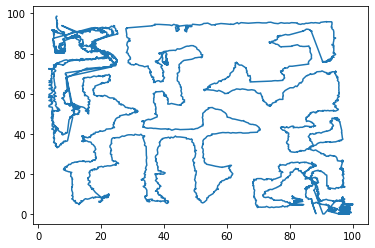

In [84]:
# position number 13
behav_positions = behav_mat['behav'][0][0][15]
behav_time = behav_mat['behav'][0][0][9]
# delete first 50 frames (~1.7s), when the mouse is not in the maze
delete_start = 50
behav_positions = np.delete(behav_positions, range(0,delete_start),0)
behav_time = np.delete(behav_time, range(0,delete_start))

# delete NAN values
nan_mask = np.isnan(behav_positions).any(axis=1)
end_index = np.where(nan_mask)
behav_time_original = behav_time
behav_positions = behav_positions[~nan_mask, ]
behav_time = behav_time[~nan_mask]
# get start, end time
start_time = behav_time[0]
end_time = behav_time[-1]
total_time = end_time- start_time
stay_time = np.append(np.ediff1d(behav_time),0)
# get end index
end_index = np.where(behav_time_original == end_time)[0][0]
behav_time_original = behav_time_original[0:(end_index+1)]
# define behavior x, y, roi
behav_x = behav_positions[:,0]
behav_y = behav_positions[:,1]
behav_roi = behav_mat['behav'][0][0][12][0]
track_length = behav_mat['behav'][0][0][-1][0]
plt.plot(behav_positions[:,0], behav_positions[:,1])
roi = np.int32([behav_roi[0], behav_roi[0]+behav_roi[2], behav_roi[1], behav_roi[1]+behav_roi[3]] )


In [85]:
roi

array([  9, 354,  20, 359])

In [90]:
ori_positions = behav_positions * behav_roi[2]/track_length


In [96]:
np.max(behav_positions)

100.07926870404103

In [97]:
occu_time

array([[3.5200e+02, 5.1200e+02, 9.6000e+02, 6.4000e+01, 2.2250e+03,
        3.6160e+03, 6.8950e+03, 3.0720e+03, 4.8640e+03, 2.2080e+03,
        1.8542e+04, 9.3310e+03],
       [9.2800e+02, 5.9200e+02, 6.7200e+02, 1.1040e+03, 2.1920e+03,
        6.4000e+01, 4.1610e+03, 9.1100e+02, 8.6400e+02, 2.2720e+03,
        4.8320e+03, 6.8150e+03],
       [2.2400e+03, 3.2000e+01, 5.2800e+02, 5.6000e+02, 4.3200e+02,
        1.0560e+03, 1.2800e+02, 6.7200e+02, 1.8560e+03, 7.2320e+03,
        4.4160e+03, 5.1840e+03],
       [3.8400e+02, 7.6800e+02, 3.0400e+02, 0.0000e+00, 7.0400e+02,
        7.3600e+02, 1.6320e+03, 0.0000e+00, 0.0000e+00, 7.6800e+02,
        5.6000e+02, 2.5280e+03],
       [1.8080e+03, 6.8900e+02, 1.0230e+03, 6.4000e+02, 6.7200e+02,
        9.0100e+02, 4.6000e+02, 1.2630e+03, 2.1280e+03, 3.8880e+03,
        5.4400e+02, 2.8800e+02],
       [3.2000e+01, 4.0000e+02, 1.5900e+02, 1.7700e+02, 5.6000e+02,
        3.3600e+02, 4.9600e+02, 4.0000e+02, 3.3600e+02, 6.8800e+02,
        5.2800e+02,

In [7]:
behav_mat['__header__']

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri May  7 19:08:40 2021'

In [9]:
test = loadmat('behav_testv73.mat');

NotImplementedError: Please use HDF reader for matlab v7.3 files

In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pickle
import cv2
import numpy as np
import time

behav_mat = loadmat('behav_new_test.mat');

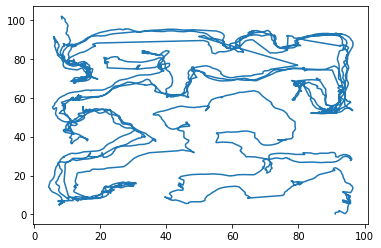

In [3]:
# position number 13
behav_positions = behav_mat['behav'][0][0][15]
behav_time = behav_mat['behav'][0][0][9]
# delete first 50 frames (~1.7s), when the mouse is not in the maze
delete_start = 50
behav_positions = np.delete(behav_positions, range(0,delete_start),0)
behav_time = np.delete(behav_time, range(0,delete_start))

# delete NAN values
nan_mask = np.isnan(behav_positions).any(axis=1)
end_index = np.where(nan_mask)
behav_time_original = behav_time
behav_positions = behav_positions[~nan_mask, ]
behav_time = behav_time[~nan_mask]
# get start, end time
start_time = behav_time[0]
end_time = behav_time[-1]
total_time = end_time- start_time
stay_time = np.append(np.ediff1d(behav_time),0)
# get end index
end_index = np.where(behav_time_original == end_time)[0][0]
behav_time_original = behav_time_original[0:(end_index+1)]
# define behavior x, y, roi
behav_x = behav_positions[:,0]
behav_y = behav_positions[:,1]
behav_roi = behav_mat['behav'][0][0][12][0]
track_length = behav_mat['behav'][0][0][-1][0]
plt.plot(behav_positions[:,0], behav_positions[:,1])
roi = np.int32([behav_roi[0], behav_roi[0]+behav_roi[2], behav_roi[1], behav_roi[1]+behav_roi[3]] )


In [14]:
occu_time

array([[4.3200e+02, 4.6400e+02, 1.0400e+03, 1.2800e+02, 2.2570e+03,
        4.3340e+03, 8.1460e+03, 3.0230e+03, 4.8640e+03, 2.2880e+03,
        1.8815e+04, 9.6960e+03],
       [1.2650e+03, 5.9200e+02, 6.7200e+02, 1.0400e+03, 2.1920e+03,
        1.2800e+02, 2.3200e+03, 1.0560e+03, 8.3200e+02, 2.3200e+03,
        6.0800e+03, 6.4210e+03],
       [1.4070e+03, 4.1600e+02, 4.6400e+02, 6.2400e+02, 4.6400e+02,
        9.9200e+02, 2.7200e+02, 5.2800e+02, 1.7920e+03, 7.9420e+03,
        2.5060e+03, 6.0600e+03],
       [5.4400e+02, 6.0800e+02, 5.6000e+02, 2.0800e+02, 8.3200e+02,
        8.6500e+02, 1.5360e+03, 0.0000e+00, 0.0000e+00, 8.3800e+02,
        5.9200e+02, 1.1040e+03],
       [1.5840e+03, 7.2000e+02, 9.6000e+02, 4.3200e+02, 5.7600e+02,
        8.0300e+02, 5.5500e+02, 1.2320e+03, 2.1280e+03, 4.3190e+03,
        4.2700e+02, 2.8800e+02],
       [1.2800e+02, 6.2400e+02, 3.3500e+02, 3.0500e+02, 5.6000e+02,
        3.3600e+02, 4.3200e+02, 4.3200e+02, 3.0400e+02, 4.6400e+02,
        4.6400e+02,

In [5]:
behav_mat['behav'][0][0][15]

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])

In [23]:
np.max(behav_positions)

96.5986726527425

In [24]:
end_index

8029

In [28]:
behav_positions.shape

(6961, 2)

In [29]:
behav_time_original.shape

(8030,)

In [30]:
behav_positions = behav_mat['behav'][0][0][14]
behav_positions.shape

(8080, 2)

In [31]:
behav_positions = np.delete(behav_positions, range(0,delete_start),0)
behav_time = np.delete(behav_time, range(0,delete_start))


In [32]:
behav_time.shape

(6911,)

In [33]:
nan_mask = np.isnan(behav_positions).any(axis=1)


In [35]:
nan_mask.shape

(8030,)

In [36]:
behav_positions.shape

(8030, 2)

In [40]:
# position number 13
behav_positions = behav_mat['behav'][0][0][14]
behav_time = behav_mat['behav'][0][0][9]
# delete first 50 frames (~1.7s), when the mouse is not in the maze
delete_start = 50
behav_positions = np.delete(behav_positions, range(0,delete_start),0)
behav_time = np.delete(behav_time, range(0,delete_start))

# delete NAN values
nan_mask = np.isnan(behav_positions).any(axis=1)
end_index = np.where(nan_mask)
behav_time_original = behav_time
behav_positions = behav_positions[~nan_mask, ]
behav_time = behav_time[~nan_mask]


In [42]:
print(behav_positions.shape)
print(behav_time.shape)

print(nan_mask.shape)

(6961, 2)
(6961,)
(8030,)


In [44]:
i=10
behav_positions[i,] - behav_positions[i-1,]

array([-0.37296785,  0.26107749])

In [54]:
np.sqrt(np.sum(np.square(behav_positions[i,] - behav_positions[i-1,])))

0.455265278047009

In [49]:
behav_positions[i,] - behav_positions[i-1,]

array([-0.37296785,  0.26107749])

In [50]:
0.37296785

TypeError: unsupported operand type(s) for ^: 'float' and 'int'

In [53]:
behav_time[i] - behav_time[i-1]


32

In [68]:
np.min(stay_time)

1

In [78]:
behav_time_tmp

array([  2127,   2159,   2191, ..., 271151, 271183, 271215])

In [121]:
activation.shape

(6961,)

In [122]:
processed_pos.shape

(6830, 2)

In [46]:
roi

array([  7, 390,   6, 374])

7.621495327102777

In [3]:
behav_positions

array([[ 5.17803696, 91.9863036 ],
       [ 5.20290148, 92.3095424 ],
       [ 5.22154987, 92.29089401],
       ...,
       [88.6503134 ,  2.20465439],
       [88.82436506,  2.05961134],
       [89.06472212,  1.7156521 ]])

In [8]:
track_length

array([100], dtype=uint8)

In [9]:
behav_roi

array([  7.62149533,   6.21028037, 383.02803738, 368.09345794])

In [10]:
behav_positions

array([[ 5.17803696, 91.9863036 ],
       [ 5.20290148, 92.3095424 ],
       [ 5.22154987, 92.29089401],
       ...,
       [88.6503134 ,  2.20465439],
       [88.82436506,  2.05961134],
       [89.06472212,  1.7156521 ]])